### Load train_df and test_df using pickle

In [1]:
import pickle
import pandas as pd

with open('train_df.pkl', 'rb') as f:
    train_df = pickle.load(f)

with open('test_df.pkl', 'rb') as f:
    test_df = pickle.load(f)

train_df.head()
# test_df.head()

,image_id,healthy,multiple_diseases,rust,scab,image_path,label,target
0,Train_0,0,0,0,1,images/Train_0.jpg,scab,3
1,Train_1,0,1,0,0,images/Train_1.jpg,multiple_diseases,1
2,Train_2,1,0,0,0,images/Train_2.jpg,healthy,0
3,Train_3,0,0,1,0,images/Train_3.jpg,rust,2
4,Train_4,1,0,0,0,images/Train_4.jpg,healthy,0


### reload plant_pathology_data library and load datas

In [2]:
import importlib
import plant_pathology_data
importlib.reload(plant_pathology_data)

<module 'plant_pathology_data' from '/Users/jungchulwoo/Desktop/Coding/DL/DL_Computer_Vision/plant_pathology/plant_pathology_data.py'>

In [14]:
from plant_pathology_data import plant_data_loader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['target'], random_state=42)

train_transform = A.Compose([
    A.VerticalFlip(p=0.4),
    A.HorizontalFlip(p=0.4),
    A.Rotate(limit=15, p=0.4),
    A.OneOf([
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.3),
        A.RandomBrightnessContrast(brightness_limit=8, contrast_limit=8, p=0.3),
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),
    ], p=0.3),
    A.Blur(blur_limit=3, p=0.3),
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_loader, val_loader = plant_data_loader(train_df, val_df, train_transform=train_transform, val_transform=val_transform)

### Choose one pre-trained model from timm
#### -> deit3_small_patch16_224.fb_in22k_ft_in1k: 
#### One of the fastest image classification models with 83% accuracy in ImageNet-1k .

In [15]:
from timm import create_model

model = create_model('deit3_small_patch16_224.fb_in22k_ft_in1k', pretrained=True, num_classes=4)


In [16]:
from torchinfo import summary

summary(model, input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params"],
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #
VisionTransformer (VisionTransformer)    [1, 3, 224, 224]          [1, 4]                    75,648
├─PatchEmbed (patch_embed)               [1, 3, 224, 224]          [1, 196, 384]             --
│    └─Conv2d (proj)                     [1, 3, 224, 224]          [1, 384, 14, 14]          295,296
│    └─Identity (norm)                   [1, 196, 384]             [1, 196, 384]             --
├─Dropout (pos_drop)                     [1, 197, 384]             [1, 197, 384]             --
├─Identity (patch_drop)                  [1, 197, 384]             [1, 197, 384]             --
├─Identity (norm_pre)                    [1, 197, 384]             [1, 197, 384]             --
├─Sequential (blocks)                    [1, 197, 384]             [1, 197, 384]             --
│    └─Block (0)                         [1, 197, 384]             [1, 197, 384]             --
│    │    └─LayerNorm (nor

In [17]:
model.pretrained_cfg

{'url': 'https://dl.fbaipublicfiles.com/deit/deit_3_small_224_21k.pth',
 'hf_hub_id': 'timm/deit3_small_patch16_224.fb_in22k_ft_in1k',
 'architecture': 'deit3_small_patch16_224',
 'tag': 'fb_in22k_ft_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': True,
 'interpolation': 'bicubic',
 'crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': None,
 'first_conv': 'patch_embed.proj',
 'classifier': 'head'}

### Training Model without cutmix

#### Fine Tuning -  first step : training only 'head' layer

In [18]:
def freeze_feature_extractor(model):
    for name, param in model.named_parameters():
        if 'head' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model

In [ ]:
import torch.nn as nn
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from trainer_V2 import Trainer
from predictor_V2 import Predictor

model = freeze_feature_extractor(model)
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

trainer = Trainer(model, train_loader, val_loader, optimizer=optimizer, scheduler=scheduler, early_patience=10)

fing_history = trainer.fit(epochs=30)


Epoch 1 [Training..]:   1%|▏         | 1/73 [00:01<01:13,  1.02s/it]/Users/jungchulwoo/Desktop/Coding/DL/DL_Computer_Vision/plant_pathology/plant_venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
Epoch 1 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it, auroc=0.834, loss=0.696]


Epoch 1 - Train Loss: 0.9349 - Train AUROC: 0.7625 - Val Loss: 0.6965 - Val AUROC: 0.8337 - LR: 0.001000


Epoch 2 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, auroc=0.878, loss=0.526]


Epoch 2 - Train Loss: 0.7199 - Train AUROC: 0.8396 - Val Loss: 0.5260 - Val AUROC: 0.8784 - LR: 0.001000


Epoch 3 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it, auroc=0.901, loss=0.497]


Epoch 3 - Train Loss: 0.6430 - Train AUROC: 0.8856 - Val Loss: 0.4969 - Val AUROC: 0.9009 - LR: 0.001000


Epoch 4 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, auroc=0.896, loss=0.469]


Epoch 4 - Train Loss: 0.6097 - Train AUROC: 0.8886 - Val Loss: 0.4686 - Val AUROC: 0.8959 - LR: 0.001000


Epoch 5 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it, auroc=0.901, loss=0.457]


Epoch 5 - Train Loss: 0.6008 - Train AUROC: 0.8918 - Val Loss: 0.4569 - Val AUROC: 0.9015 - LR: 0.001000


Epoch 6 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, auroc=0.903, loss=0.435]


Epoch 6 - Train Loss: 0.5668 - Train AUROC: 0.9057 - Val Loss: 0.4352 - Val AUROC: 0.9032 - LR: 0.001000


Epoch 7 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it, auroc=0.917, loss=0.458]


Epoch 7 - Train Loss: 0.5481 - Train AUROC: 0.9094 - Val Loss: 0.4582 - Val AUROC: 0.9168 - LR: 0.001000


Epoch 8 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, auroc=0.903, loss=0.468]


Epoch 8 - Train Loss: 0.5436 - Train AUROC: 0.9172 - Val Loss: 0.4679 - Val AUROC: 0.9029 - LR: 0.001000


Epoch 9 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it, auroc=0.919, loss=0.411]


Epoch 9 - Train Loss: 0.5536 - Train AUROC: 0.9108 - Val Loss: 0.4110 - Val AUROC: 0.9193 - LR: 0.001000


Epoch 10 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, auroc=0.916, loss=0.421]


Epoch 10 - Train Loss: 0.5263 - Train AUROC: 0.9225 - Val Loss: 0.4207 - Val AUROC: 0.9165 - LR: 0.001000


Epoch 11 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, auroc=0.918, loss=0.425]


Epoch 11 - Train Loss: 0.5267 - Train AUROC: 0.9152 - Val Loss: 0.4247 - Val AUROC: 0.9176 - LR: 0.001000


Epoch 12 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.92s/it, auroc=0.931, loss=0.397]


Epoch 12 - Train Loss: 0.5265 - Train AUROC: 0.9203 - Val Loss: 0.3965 - Val AUROC: 0.9311 - LR: 0.001000


Epoch 13 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, auroc=0.939, loss=0.425]


Epoch 13 - Train Loss: 0.5122 - Train AUROC: 0.9191 - Val Loss: 0.4248 - Val AUROC: 0.9389 - LR: 0.001000


Epoch 14 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it, auroc=0.934, loss=0.393]


Epoch 14 - Train Loss: 0.5310 - Train AUROC: 0.9134 - Val Loss: 0.3927 - Val AUROC: 0.9340 - LR: 0.001000


Epoch 15 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, auroc=0.934, loss=0.395]


Epoch 15 - Train Loss: 0.4867 - Train AUROC: 0.9254 - Val Loss: 0.3950 - Val AUROC: 0.9337 - LR: 0.001000


Epoch 16 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, auroc=0.944, loss=0.378]


Epoch 16 - Train Loss: 0.4937 - Train AUROC: 0.9291 - Val Loss: 0.3775 - Val AUROC: 0.9438 - LR: 0.001000


Epoch 17 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, auroc=0.929, loss=0.406]


Epoch 17 - Train Loss: 0.4932 - Train AUROC: 0.9313 - Val Loss: 0.4057 - Val AUROC: 0.9291 - LR: 0.001000


Epoch 18 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, auroc=0.95, loss=0.403] 


Epoch 18 - Train Loss: 0.5034 - Train AUROC: 0.9268 - Val Loss: 0.4032 - Val AUROC: 0.9497 - LR: 0.001000


Epoch 19 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it, auroc=0.932, loss=0.43] 


Epoch 19 - Train Loss: 0.4880 - Train AUROC: 0.9276 - Val Loss: 0.4297 - Val AUROC: 0.9321 - LR: 0.001000


Epoch 20 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it, auroc=0.945, loss=0.366]


Epoch 20 - Train Loss: 0.4611 - Train AUROC: 0.9406 - Val Loss: 0.3657 - Val AUROC: 0.9454 - LR: 0.001000


Epoch 21 [Validation..]: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, auroc=0.942, loss=0.374]


Epoch 21 - Train Loss: 0.5030 - Train AUROC: 0.9206 - Val Loss: 0.3739 - Val AUROC: 0.9419 - LR: 0.001000


Epoch 22 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it, auroc=0.94, loss=0.374] 


Epoch 22 - Train Loss: 0.5041 - Train AUROC: 0.9314 - Val Loss: 0.3743 - Val AUROC: 0.9401 - LR: 0.001000


Epoch 23 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, auroc=0.951, loss=0.372]


Epoch 23 - Train Loss: 0.4630 - Train AUROC: 0.9261 - Val Loss: 0.3719 - Val AUROC: 0.9510 - LR: 0.001000


Epoch 24 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, auroc=0.954, loss=0.386]


Epoch 24 - Train Loss: 0.4584 - Train AUROC: 0.9395 - Val Loss: 0.3855 - Val AUROC: 0.9539 - LR: 0.001000


Epoch 25 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it, auroc=0.952, loss=0.343]


Epoch 25 - Train Loss: 0.4743 - Train AUROC: 0.9381 - Val Loss: 0.3426 - Val AUROC: 0.9519 - LR: 0.001000


Epoch 26 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it, auroc=0.952, loss=0.417]


Epoch 26 - Train Loss: 0.4834 - Train AUROC: 0.9307 - Val Loss: 0.4168 - Val AUROC: 0.9524 - LR: 0.001000


Epoch 27 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it, auroc=0.948, loss=0.383]


Epoch 27 - Train Loss: 0.5094 - Train AUROC: 0.9281 - Val Loss: 0.3833 - Val AUROC: 0.9483 - LR: 0.001000


Epoch 28 [Validation..]: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it, auroc=0.952, loss=0.346]


Epoch 28 - Train Loss: 0.4775 - Train AUROC: 0.9360 - Val Loss: 0.3462 - Val AUROC: 0.9523 - LR: 0.001000


Epoch 29 [Validation..]: 100%|██████████| 5/5 [00:11<00:00,  2.29s/it, auroc=0.948, loss=0.387]


Epoch 29 - Train Loss: 0.4657 - Train AUROC: 0.9392 - Val Loss: 0.3873 - Val AUROC: 0.9482 - LR: 0.001000


Epoch 30 [Validation..]: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it, auroc=0.949, loss=0.375]

Epoch 30 - Train Loss: 0.4875 - Train AUROC: 0.9295 - Val Loss: 0.3749 - Val AUROC: 0.9486 - LR: 0.001000
Early stopping at epoch 30


#### Fine Tuning -  second step : training all layers

In [21]:
for param in model.parameters():
    param.requires_grad = True

optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

trainer = Trainer(model, train_loader, val_loader, optimizer=optimizer, scheduler=scheduler, early_patience=10)

result_history = trainer.fit(epochs=30)


Epoch 1 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.90s/it, auroc=0.789, loss=0.911]


Epoch 1 - Train Loss: 1.0877 - Train AUROC: 0.6957 - Val Loss: 0.9107 - Val AUROC: 0.7890 - LR: 0.001000


Epoch 2 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, auroc=0.798, loss=0.855]


Epoch 2 - Train Loss: 1.0005 - Train AUROC: 0.7206 - Val Loss: 0.8546 - Val AUROC: 0.7976 - LR: 0.001000


Epoch 3 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it, auroc=0.777, loss=0.902]


Epoch 3 - Train Loss: 0.9871 - Train AUROC: 0.7296 - Val Loss: 0.9023 - Val AUROC: 0.7771 - LR: 0.001000


Epoch 4 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it, auroc=0.812, loss=0.922]


Epoch 4 - Train Loss: 0.9346 - Train AUROC: 0.7458 - Val Loss: 0.9220 - Val AUROC: 0.8120 - LR: 0.001000


Epoch 5 [Training..]:   1%|▏         | 1/73 [00:01<02:12,  1.84s/it]/Users/jungchulwoo/Desktop/Coding/DL/DL_Computer_Vision/plant_pathology/plant_venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
Epoch 5 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it, auroc=0.831, loss=1.06]


Epoch 5 - Train Loss: 0.9488 - Train AUROC: 0.7445 - Val Loss: 1.0644 - Val AUROC: 0.8312 - LR: 0.001000


Epoch 6 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it, auroc=0.757, loss=0.981]


Epoch 6 - Train Loss: 1.0002 - Train AUROC: 0.7263 - Val Loss: 0.9811 - Val AUROC: 0.7574 - LR: 0.000100


Epoch 7 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it, auroc=0.807, loss=0.811]


Epoch 7 - Train Loss: 0.9803 - Train AUROC: 0.7385 - Val Loss: 0.8109 - Val AUROC: 0.8070 - LR: 0.000100


Epoch 8 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it, auroc=0.828, loss=0.745]


Epoch 8 - Train Loss: 0.8664 - Train AUROC: 0.7916 - Val Loss: 0.7453 - Val AUROC: 0.8285 - LR: 0.000100


Epoch 9 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it, auroc=0.859, loss=0.693]


Epoch 9 - Train Loss: 0.8364 - Train AUROC: 0.7884 - Val Loss: 0.6932 - Val AUROC: 0.8593 - LR: 0.000100


Epoch 10 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it, auroc=0.867, loss=0.664]


Epoch 10 - Train Loss: 0.7471 - Train AUROC: 0.8414 - Val Loss: 0.6644 - Val AUROC: 0.8670 - LR: 0.000100


Epoch 11 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it, auroc=0.892, loss=0.605]


Epoch 11 - Train Loss: 0.7177 - Train AUROC: 0.8534 - Val Loss: 0.6047 - Val AUROC: 0.8920 - LR: 0.000100


Epoch 12 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, auroc=0.907, loss=0.548]


Epoch 12 - Train Loss: 0.7006 - Train AUROC: 0.8456 - Val Loss: 0.5482 - Val AUROC: 0.9067 - LR: 0.000100


Epoch 13 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it, auroc=0.918, loss=0.547]


Epoch 13 - Train Loss: 0.6485 - Train AUROC: 0.8574 - Val Loss: 0.5473 - Val AUROC: 0.9178 - LR: 0.000100


Epoch 14 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.86s/it, auroc=0.919, loss=0.503]


Epoch 14 - Train Loss: 0.6665 - Train AUROC: 0.8608 - Val Loss: 0.5032 - Val AUROC: 0.9194 - LR: 0.000100


Epoch 15 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it, auroc=0.914, loss=0.545]


Epoch 15 - Train Loss: 0.6633 - Train AUROC: 0.8511 - Val Loss: 0.5450 - Val AUROC: 0.9139 - LR: 0.000100


Epoch 16 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it, auroc=0.932, loss=0.488]


Epoch 16 - Train Loss: 0.6388 - Train AUROC: 0.8681 - Val Loss: 0.4877 - Val AUROC: 0.9317 - LR: 0.000100


Epoch 17 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it, auroc=0.911, loss=0.469]


Epoch 17 - Train Loss: 0.6273 - Train AUROC: 0.8747 - Val Loss: 0.4694 - Val AUROC: 0.9107 - LR: 0.000100


Epoch 18 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, auroc=0.913, loss=0.467]


Epoch 18 - Train Loss: 0.5666 - Train AUROC: 0.8911 - Val Loss: 0.4670 - Val AUROC: 0.9130 - LR: 0.000100


Epoch 19 [Validation..]: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it, auroc=0.929, loss=0.44] 


Epoch 19 - Train Loss: 0.5653 - Train AUROC: 0.8927 - Val Loss: 0.4396 - Val AUROC: 0.9289 - LR: 0.000100


Epoch 20 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.98s/it, auroc=0.925, loss=0.425]


Epoch 20 - Train Loss: 0.5745 - Train AUROC: 0.8937 - Val Loss: 0.4253 - Val AUROC: 0.9245 - LR: 0.000100


Epoch 21 [Validation..]: 100%|██████████| 5/5 [00:10<00:00,  2.04s/it, auroc=0.932, loss=0.417]


Epoch 21 - Train Loss: 0.5871 - Train AUROC: 0.8844 - Val Loss: 0.4168 - Val AUROC: 0.9317 - LR: 0.000100


Epoch 22 [Validation..]: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it, auroc=0.941, loss=0.435]


Epoch 22 - Train Loss: 0.5788 - Train AUROC: 0.8855 - Val Loss: 0.4348 - Val AUROC: 0.9407 - LR: 0.000100


Epoch 23 [Validation..]: 100%|██████████| 5/5 [00:11<00:00,  2.30s/it, auroc=0.935, loss=0.439]


Epoch 23 - Train Loss: 0.5783 - Train AUROC: 0.8897 - Val Loss: 0.4388 - Val AUROC: 0.9348 - LR: 0.000100


Epoch 24 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it, auroc=0.93, loss=0.422] 


Epoch 24 - Train Loss: 0.5349 - Train AUROC: 0.8971 - Val Loss: 0.4217 - Val AUROC: 0.9295 - LR: 0.000100


Epoch 25 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it, auroc=0.921, loss=0.483]


Epoch 25 - Train Loss: 0.5274 - Train AUROC: 0.9066 - Val Loss: 0.4830 - Val AUROC: 0.9209 - LR: 0.000010


Epoch 26 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it, auroc=0.939, loss=0.384]


Epoch 26 - Train Loss: 0.5448 - Train AUROC: 0.8997 - Val Loss: 0.3843 - Val AUROC: 0.9394 - LR: 0.000010


Epoch 27 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it, auroc=0.941, loss=0.378]


Epoch 27 - Train Loss: 0.5277 - Train AUROC: 0.9159 - Val Loss: 0.3778 - Val AUROC: 0.9410 - LR: 0.000010


Epoch 28 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.85s/it, auroc=0.942, loss=0.372]


Epoch 28 - Train Loss: 0.5056 - Train AUROC: 0.9115 - Val Loss: 0.3717 - Val AUROC: 0.9421 - LR: 0.000010


Epoch 29 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.84s/it, auroc=0.942, loss=0.374]


Epoch 29 - Train Loss: 0.5021 - Train AUROC: 0.9101 - Val Loss: 0.3739 - Val AUROC: 0.9421 - LR: 0.000010


Epoch 30 [Validation..]: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it, auroc=0.943, loss=0.367]

Epoch 30 - Train Loss: 0.5049 - Train AUROC: 0.9115 - Val Loss: 0.3666 - Val AUROC: 0.9432 - LR: 0.000010


### Save model's parameters for safekeeping


In [24]:
import torch

save_path = 'state_dict'

torch.save(model.state_dict(), save_path)

### Visualize the training summary

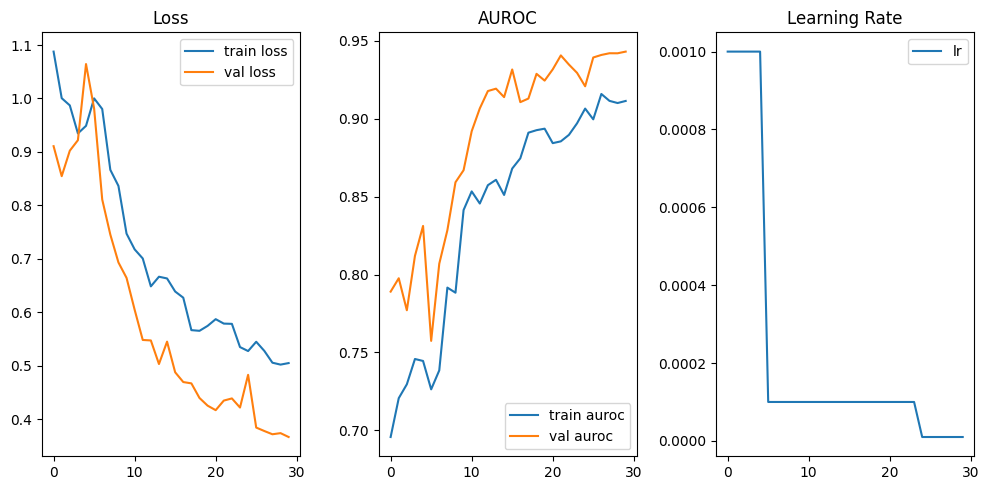

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

ax[0].plot(result_history['train_loss'], label='train loss')
ax[0].plot(result_history['val_loss'], label='val loss')
ax[0].legend()
ax[0].set_title('Loss')

ax[1].plot(result_history['train_auroc'], label='train auroc')
ax[1].plot(result_history['val_auroc'], label='val auroc')
ax[1].legend()
ax[1].set_title('AUROC')

ax[2].plot(result_history['lr'], label='lr')
ax[2].legend()
ax[2].set_title('Learning Rate')

plt.tight_layout()
plt.show()

### Prediction and Submission

In [34]:
import importlib
import plant_pathology_data
import predictor_V2
importlib.reload(predictor_V2)
importlib.reload(plant_pathology_data)

<module 'plant_pathology_data' from '/Users/jungchulwoo/Desktop/Coding/DL/DL_Computer_Vision/plant_pathology/plant_pathology_data.py'>

### Prepare test loader

In [37]:
import pandas as pd
import plant_pathology_data

test_df = pd.read_csv('test.csv')
test_df['image_path'] = test_df['image_id'].apply(lambda x: f'images/{x}.jpg')

test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_loader = plant_pathology_data.plant_data_loader(train_df=test_df, batch_size=16, train_transform=test_transform, is_test=True)

In [38]:
from predictor_V2 import Predictor
import numpy as np 

predictor = Predictor(model)

prob_all_list= []

for image in test_loader:
    probas = predictor.predict_proba(image).cpu().numpy()
    prob_all_list.extend(probas)

prob_all = np.array(prob_all_list)

pred_df = pd.DataFrame(prob_all, columns=['healthy', 'multiple_diseases', 'rust', 'scab'])
submit_df = pd.concat([test_df['image_id'], pred_df], axis=1)
submit_df.to_csv('submission.csv', index=False)